<a href="https://colab.research.google.com/github/DimasVeliz/MachineLearning6hCourse/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install -q sklearn

In [22]:
%tensorflow_version 2.x 

In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf



In [30]:
dftrain= pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval= pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')


In [27]:
dfeval

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y
...,...,...,...,...,...,...,...,...,...,...
259,1,female,25.0,0,1,26.0000,Second,unknown,Southampton,n
260,0,male,33.0,0,0,7.8958,Third,unknown,Southampton,y
261,0,female,39.0,0,5,29.1250,Third,unknown,Queenstown,n
262,0,male,27.0,0,0,13.0000,Second,unknown,Southampton,y


In [31]:
y_train= dftrain.pop('survived')
y_eval= dfeval.pop('survived')


In [32]:
print(y_train)

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64


In [36]:
## labels and content from the first raw
print(dftrain.loc[0], "\nha muerto? ->", y_train.loc[0])

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 
ha muerto? -> 0


In [37]:
# algunas medidas de tendencia central del dataset
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [40]:
# filas, columnas
dftrain.shape

(627, 9)

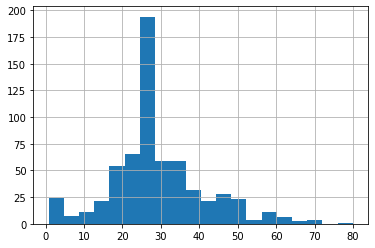

In [42]:
#imprimiendo un histograma edad vs cantidad de la edad
dftrain.age.hist(bins=20)

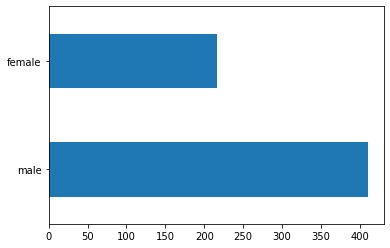

In [46]:
dftrain.sex.value_counts().plot(kind='barh')

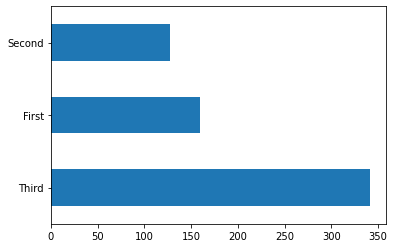

In [47]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, ' % survive')

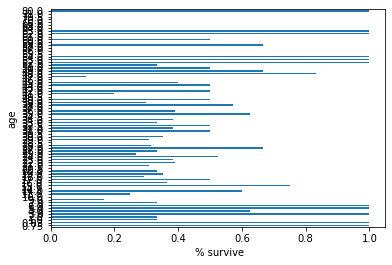

In [53]:
pd.concat([dftrain,y_train],axis=1).groupby('age').survived.mean().plot(kind='barh').set_xlabel(' % survive')


Text(0.5, 0, ' % survive')

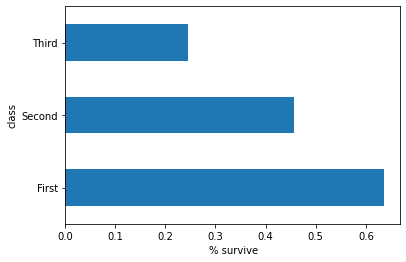

In [55]:
pd.concat([dftrain,y_train],axis=1).groupby('class').survived.mean().plot(kind='barh').set_xlabel(' % survive')


Text(0.5, 0, ' % survive')

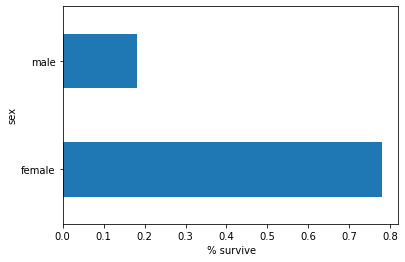

In [54]:

pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel(' % survive')

In [ ]:
## Categorical data is all the data that are not numbers such as male or female, y or n or mb, sure names.
## this data should be map into numbers

In [66]:
CATEGORICAL_COLUMS = ['sex', 'class','parch', 'deck', 'embark_town', 'alone', 'n_siblings_spouses']
NUMERIC_COLUMS= ['age', 'fare']

In [67]:
#returns the unique members of the whole column of the specified feature
vocabulary= dftrain['embark_town'].unique()
print(vocabulary)


['Southampton' 'Cherbourg' 'Queenstown' 'unknown']


In [69]:
feature_columns= []

for feature_name in CATEGORICAL_COLUMS:
  vocabulary= dftrain[feature_name].unique()
  feature_columns.append( tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))
print(feature_columns)

for feature_name in NUMERIC_COLUMS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))
print(feature_columns)


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, def

In [70]:
## batches are the amount of data that will be passed together so we dont need to hold the whole model on ram (lotes)
## epochs are the amount of times, that the model will see this dataset

In [76]:
def make_input_fn(data_df,label_df,num_epochs=10,shuffle=True, batch_size=32):
  def input_function():
    ds=tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
      ds=ds.shuffle(1000)
    ds=ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [79]:
train_input_fn = make_input_fn(data_df=dftrain,label_df=y_train)
eval_input_fn= make_input_fn(data_df=dfeval, label_df=y_eval, num_epochs=1,shuffle=False)

linear_est= tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result= linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])
print(result)


0.77272725
{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8310989, 'auc_precision_recall': 0.7899842, 'average_loss': 0.48289025, 'label/mean': 0.375, 'loss': 0.47212017, 'precision': 0.7294118, 'prediction/mean': 0.3445509, 'recall': 0.6262626, 'global_step': 200}


In [93]:
result= list(linear_est.predict(eval_input_fn))
clear_output()

print('raws calculated ->',len(result))

raw_Number=3
probability_of_person_chance_of_survival=result[raw_Number]['probabilities'][1]

print('person details: ->\n',dfeval.loc[raw_Number])
print('reality of the label ->',y_eval.loc[raw_Number])
print('value predicted for our model ->',probability_of_person_chance_of_survival)

raws calculated -> 264
person details: ->
 sex                        female
age                            55
n_siblings_spouses              0
parch                           0
fare                           16
class                      Second
deck                      unknown
embark_town           Southampton
alone                           y
Name: 3, dtype: object
reality of the label -> 1
value predicted for our model -> 0.5928799
